# Net Primary Production (NPP) - estimation of annual anomalies and trends over the last 20 years using R software: a case study in Estonia
tutors: Bruno Montibeller, Holger Virro and Iuliia Burdun <br>
contacts bruno.montibeller@ut.ee


## Introduction
**The goal of this workshop is to teach the participants how to work with spatial data in R programming software by applying the Mann-Kendall (MK) trend test and calculate Theil–Sen values on a gridded net primary production data.**

Net primary production (NPP) can be defined as the quantity of carbon assimilated per unit of area over a given period of time. It is calculated through the subtraction of the plant respiration rates from the gross primary production rates. The NPP data (named __[MOD17A3HGF](https://lpdaac.usgs.gov/products/mod17a3hgfv006/#tools)__) that we will be using is based on the data acquired by the Moderate Resolution Imaging Spectroradiometer (MODIS) remote sensor onboard of the Terra satellite. The data is calculated on annual basis using the gross primary production product of the same sensor, annual rates of growth respiration and annual maintenance respiration of live cells in wood. Additional info can be found in the __[user guide](https://lpdaac.usgs.gov/documents/495/MOD17_User_Guide_V6.pdf)__. 

MK trend test has been widely applied to infer about the temporal trends in time series of environmental variables. MK is a nonparametric test; therefore, it does not require normal distribution of the data, but it does assume no autocorrelation in the time series. The MK test has as null hypothesis that the time series has no trend, and the alternative hypothesis is that it does have a trend (upward or downward). 

The MK trend test first calculates the differences between all pairs of earlier and later data points in the time series. After that, it calculates the variance of these differences, which is posteriorly used to calculate the Z test value. Finally, the statistical significance of the trend is quantified by calculating the probability associated with the normalized Z test. If Z > 0, it indicates an increasing trend and if Z < 0 it indicates a decreasing trend. Usually, the trends are defined as significant using 95% confidence level. In addition to the trend calculation, it is also possible to quantify the magnitude of the trends. The magnitudes can be estimated by using the nonparametric Sen statistic — more specifically, the Theil–Sen estimator which is given by the median of the slopes of each pair of points. To calculate the Theil–Sen, the times series data is ordered accordingly to the time (as function of time) and a confidence interval is provided for each slope value (same as in the MK test).

## Data
### __[Estonian boundaries](https://gadm.org/data.html)__
Shapefile with Estonian political boundaries.
### __[Estonian forest cover](https://doi.org/10.1038/s41893-020-00609-y)__
The forest cover dataset used in this workshop was acquired from __[Senf and Seidl 2020]( https://doi.org/10.1038/s41893-020-00609-y)__. The authors mapped forest disturbance for all European countries annually from 1986 to 2020 using satellite images at 30 m resolution. Based on the __[forest cover layer](https://zenodo.org/record/4570157)__ and disturbance maps provided by the authors for Estonia, we removed all forest areas that suffered any disturbance during the mentioned period. By doing that, we retrieved the forest cover in 2020 for Estonia. To remove the edge effect (or border effect), we applied an inward buffer of 500 meters in the forest cover areas. In this way, we removed NPP pixels of the edges that can potentially result in biased analysis. Therefore, all analysis performed in this workshop are based on NPP pixels that overlap the called “core forest areas” (the central part of the forest areas).
### __[MODIS NPP]( https://doi.org/10.1038/s41893-020-00609-y)__
21 rasters with annual (2000–2020) Net Primary Production (NPP) at 500 meter (m) pixel resolution.

## R libraries 
* __[terra](https://cran.r-project.org/web/packages/terra/terra.pdf)__ - methods for spatial data analysis with raster and vector data.
* __[raster](https://cran.r-project.org/web/packages/raster/raster.pdf)__ - reading, writing, manipulating, analyzing and modeling of spatial data.
* __[tmap](https://cran.r-project.org/web/packages/tmap/tmap.pdf)__ - create thematic maps.
* __[sf](https://cran.r-project.org/web/packages/sf/sf.pdf)__ - support for simple features, a standardized way to encode spatial vector data.
* __[viridis](https://cran.r-project.org/web/packages/viridis/viridis.pdf)__ - color maps designed to improve graph readability for readers with common forms of color blindness and/or color vision deficiency.
* __[rgdal](https://cran.r-project.org/web/packages/rgdal/rgdal.pdf)__ - provides access to projection/transformation operations.
* __[tidyverse](https://www.tidyverse.org/)__ - set of packages designed for data science.
* __[tidyr](https://cran.r-project.org/web/packages/tidyr/tidyr.pdf)__  - tools for changing the shape and hierarchy of a dataset.
* __[wql](https://cran.r-project.org/web/packages/wql/wql.pdf)__ - functions useful for analysis of similar-frequency time series data.
* __[plyr](https://cran.r-project.org/web/packages/plyr/plyr.pdf)__ - helps summarize data quickly.
* __[maditr](https://cran.r-project.org/web/packages/maditr/maditr.pdf)__  - provides pipe-style interface for data.table package.
* __[gifski](https://cran.r-project.org/web/packages/gifski/gifski.pdf)__  - converts images to GIF animations. 

## Workflow


In [1]:
##Install libraries
install.packages(c("wql",  "maditr")) 

also installing the dependency ‘zoo’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
## Load packages "quietly" with suppressMessages and suppressWarnings
suppressMessages(suppressWarnings(require(terra)))
suppressMessages(suppressWarnings(require(raster)))
suppressMessages(suppressWarnings(require(tmap)))
suppressMessages(suppressWarnings(require(sf)))
suppressMessages(suppressWarnings(require(viridis)))
suppressMessages(suppressWarnings(require(rgdal)))
suppressMessages(suppressWarnings(require(tidyverse)))
suppressMessages(suppressWarnings(require(tidyr)))
suppressMessages(suppressWarnings(require(wql)))
suppressMessages(suppressWarnings(require(plyr)))
suppressMessages(suppressWarnings(require(maditr)))
suppressMessages(suppressWarnings(require(gifski)))
suppressMessages(suppressWarnings(require(curl)))

## Load and explore the data

### Estonian boundaries data

In [38]:
download.file("https://github.com/LandscapeGeoinformatics/ESP2021_workshop/raw/main/Data/shp/eesti.zip", destfile="eesti.zip")
unzip("eesti.zip")
est_shp <-  st_read("eesti.shp")
glimpse(est_shp)		##glimpse function shows columns and first rows of shape file

Reading layer `eesti' from data source `/home/jovyan/eesti.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 21.76431 ymin: 57.51395 xmax: 28.20904 ymax: 59.82202
Geodetic CRS:  WGS 84
Rows: 1
Columns: 3
$ GID_0    <fct> EST
$ NAME_0   <fct> Estonia
$ geometry <MULTIPOLYGON [°]> MULTIPOLYGON (((23.27234 57...


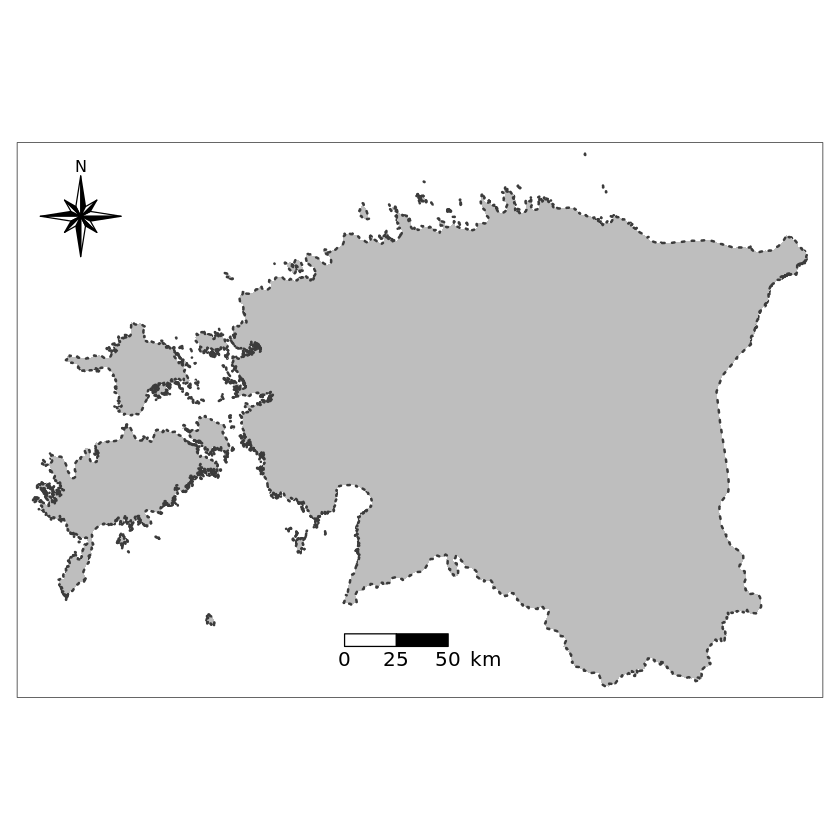

In [4]:
##Let's plot est_shp and see how it looks
tm_shape(est_shp, projection = "+proj=longlat +datum=WGS84 +no_defs ") + 
	tm_polygons(col="grey", 		##fill colour
			border.col="gray23",	##border colour
			lty = "dotted",		##dotted type of border line
			lwd = 2)+			##width of border line
	tm_compass(type = "8star", position = c("left", "top"))+	##add north arrow
	tm_scale_bar(position=c("center", "bottom"),	##add scale bar
			lwd = 1,
			breaks = c(0, 25, 50), 
			text.size = 1)

### Estonian forest cover data

In [5]:
## forest cover data as shapefile 
download.file("https://github.com/oleksandrkarasov/some/raw/main/forestcover_estonia_2020_510.zip", destfile="forestcover_estonia_2020_510.zip")
unzip("forestcover_estonia_2020_510.zip")
forest_shp <-  st_read("forestcover_estonia_2020_510.shp")
glimpse(forest_shp)

## forest core data as raster
forest_cover_rst<-raster("Data/forestcover_estonia_2020.tif")
glimpse(forest_cover_rst)

Reading layer `forestcover_estonia_2020_510' from data source `/home/jovyan/forestcover_estonia_2020_510.shp' using driver `ESRI Shapefile'
Simple feature collection with 624 features and 1 field
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 5013791 ymin: 3927869 xmax: 5357591 ymax: 4161479
Projected CRS: Lambert_Azimuthal_Equal_Area
Rows: 624
Columns: 2
$ DN       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ geometry <MULTIPOLYGON [m]> MULTIPOLYGON (((5335061 416..., MULTIPOLYGON (((…


Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded datum unknown in CRS definition,
 but +towgs84= values preserved”


Formal class 'RasterLayer' [package "raster"] with 12 slots
  ..@ file    :Formal class '.RasterFile' [package "raster"] with 13 slots
  ..@ data    :Formal class '.SingleLayerData' [package "raster"] with 13 slots
  ..@ legend  :Formal class '.RasterLegend' [package "raster"] with 5 slots
  ..@ title   : chr(0) 
  ..@ extent  :Formal class 'Extent' [package "raster"] with 4 slots
  ..@ rotated : logi FALSE
  ..@ rotation:Formal class '.Rotation' [package "raster"] with 2 slots
  ..@ ncols   : int 11981
  ..@ nrows   : int 9322
  ..@ crs     :Formal class 'CRS' [package "sp"] with 1 slot
  ..@ history : list()
  ..@ z       : list()


stars_proxy object shown at 1134 by 883 cells.



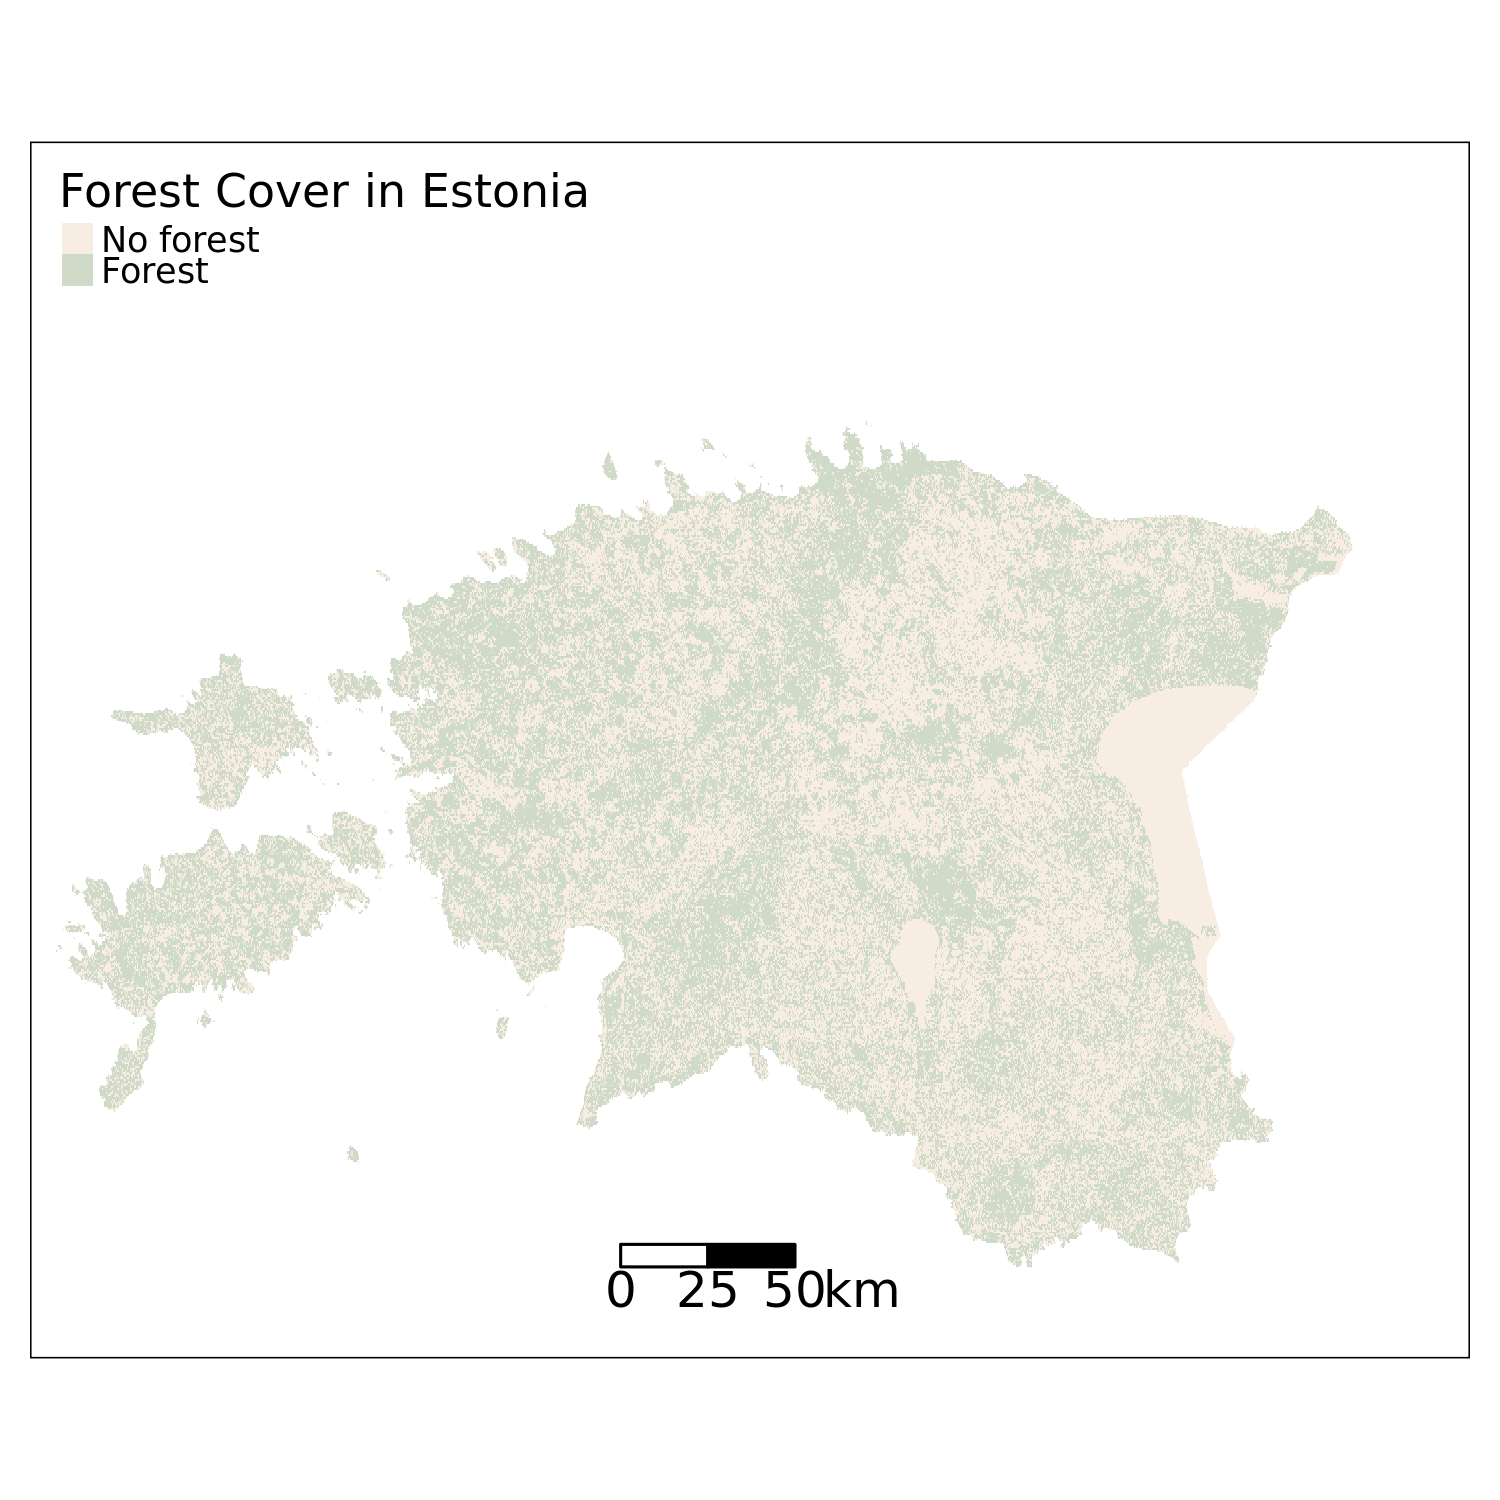

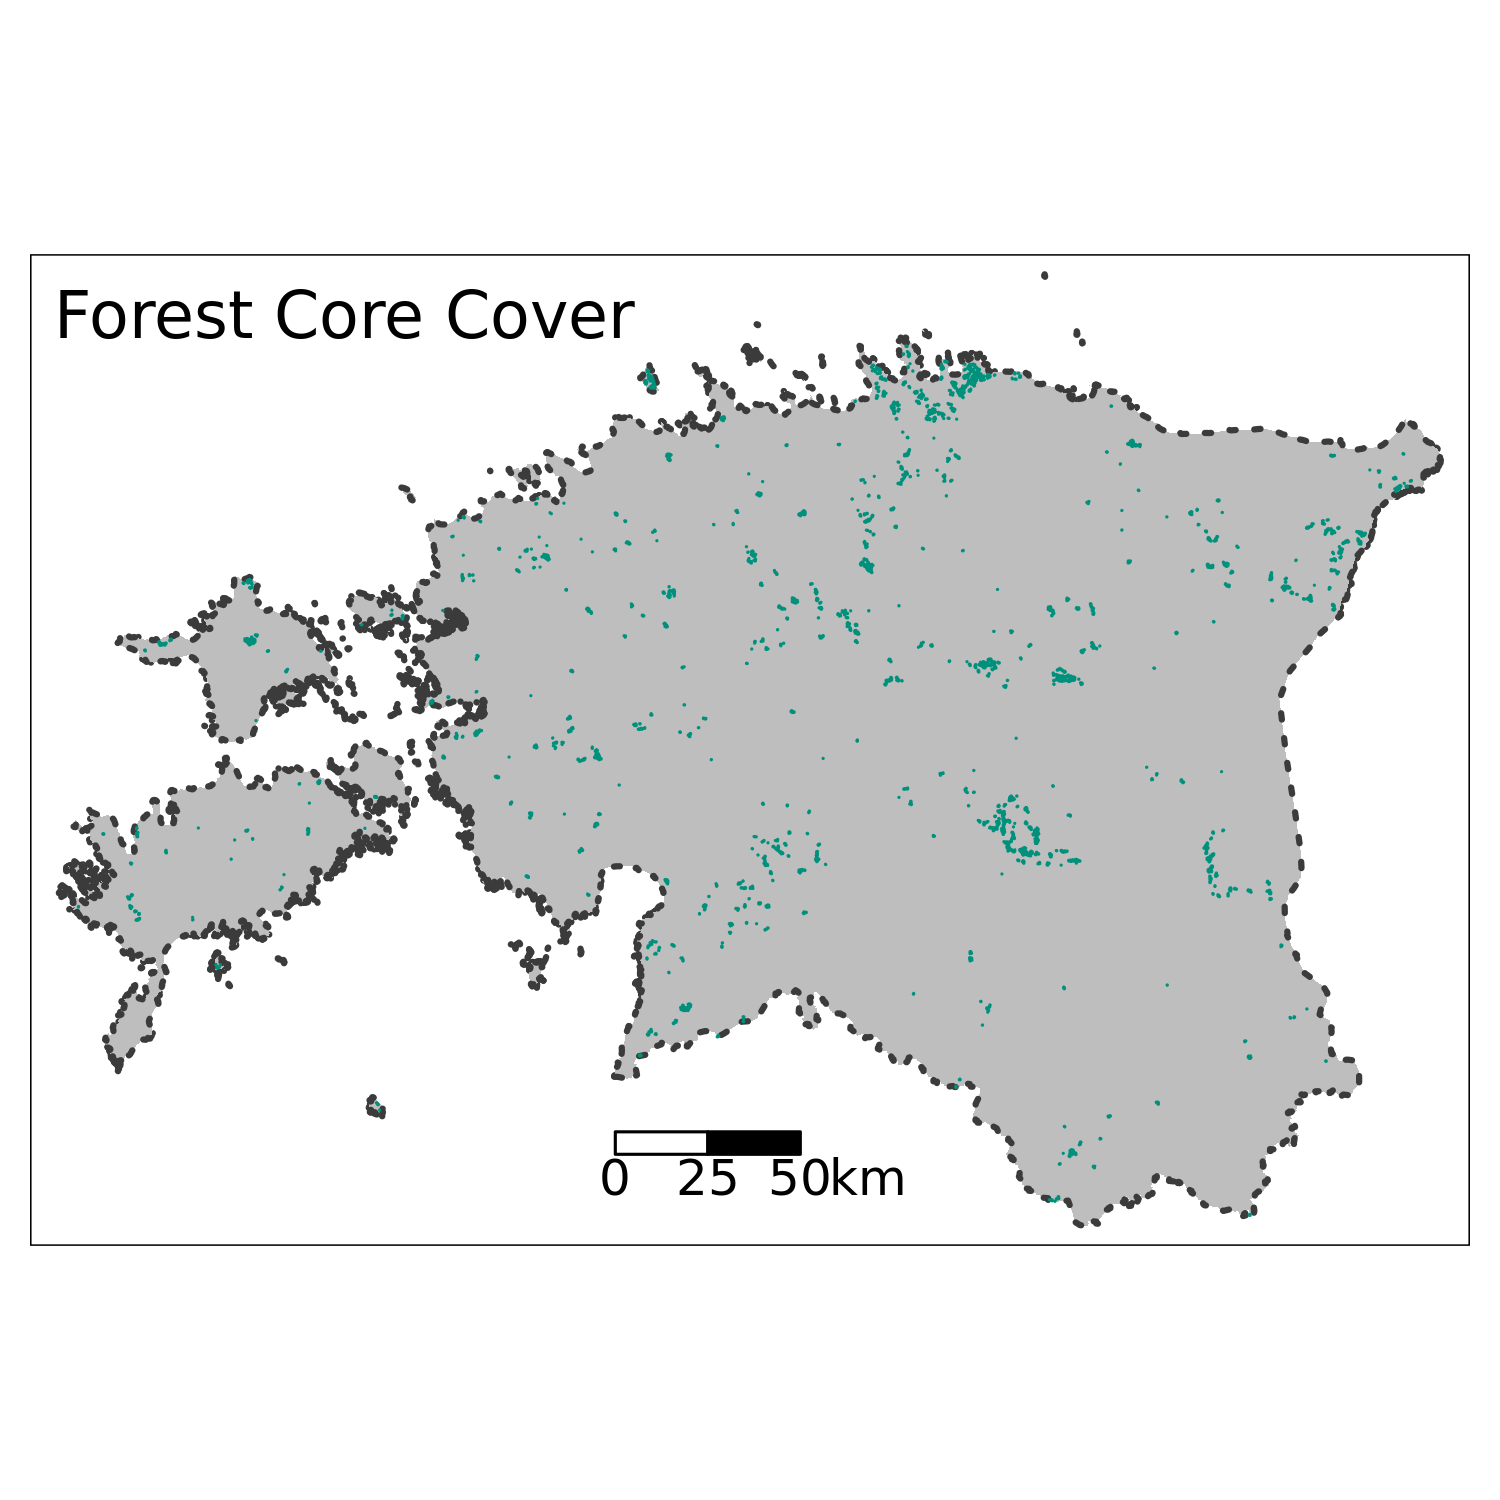

In [6]:
## Let's plot forest  cover data to see how it looks
lab<-c ("No forest", "Forest")		# set labels
cols_forest <- c("#f8ede3", "#cfdac8")		# set colours
options(repr.plot.width = 5, repr.plot.height =5, repr.plot.res = 300)

tm_shape(forest_cover_rst, projection = "+proj=longlat +datum=WGS84 +no_defs ")+
	tm_raster(style = "fixed", title = "Forest Cover in Estonia",
		breaks = c(0,0.5, 1), palette = cols_forest, labels = lab)+
	tm_scale_bar(position=c("center", "bottom"),
			lwd = 1,
			breaks = c(0, 25, 50), 
			text.size = 1)

## Let's plot forest core cover data to see how it looks
tm_shape(est_shp) + 
	tm_polygons(col="grey", 
			border.col="gray23", 
			lty = "dotted",
			lwd = 2)+
	tm_shape(forest_shp)+
	tm_polygons(col= "#00917c",
			border.col="#00917c")+ 
	tm_layout(title="Forest Core Cover")+
	tm_scale_bar(position=c("center", "bottom"),
			lwd = 1,
			breaks = c(0, 25, 50), 
			text.size = 1)

### MODIS NPP data

In [7]:
npp_rst<-list.files("Data/NPP", pattern = "001.tif", full.names = T)	
npp_list<-list.files("Data/NPP", pattern = "001.tif")
str(npp_rst)	## see the structure of npp_rst - shows the full path to raster files
str(npp_list)	## see the structure of npp_list - shows the name of raster files


 chr [1:21] "Data/NPP/MOD17A3HGF.006_Npp_500m_doy2000049_aid0001.tif" ...
 chr [1:21] "MOD17A3HGF.006_Npp_500m_doy2000049_aid0001.tif" ...


stars object downsampled to 1577 by 633 cells. See tm_shape manual (argument raster.downsample)



[1] "#C9FFB9" "#9BE787" "#6ACE55" "#37BD55" "#00AB69" "#009780" "#008C83"

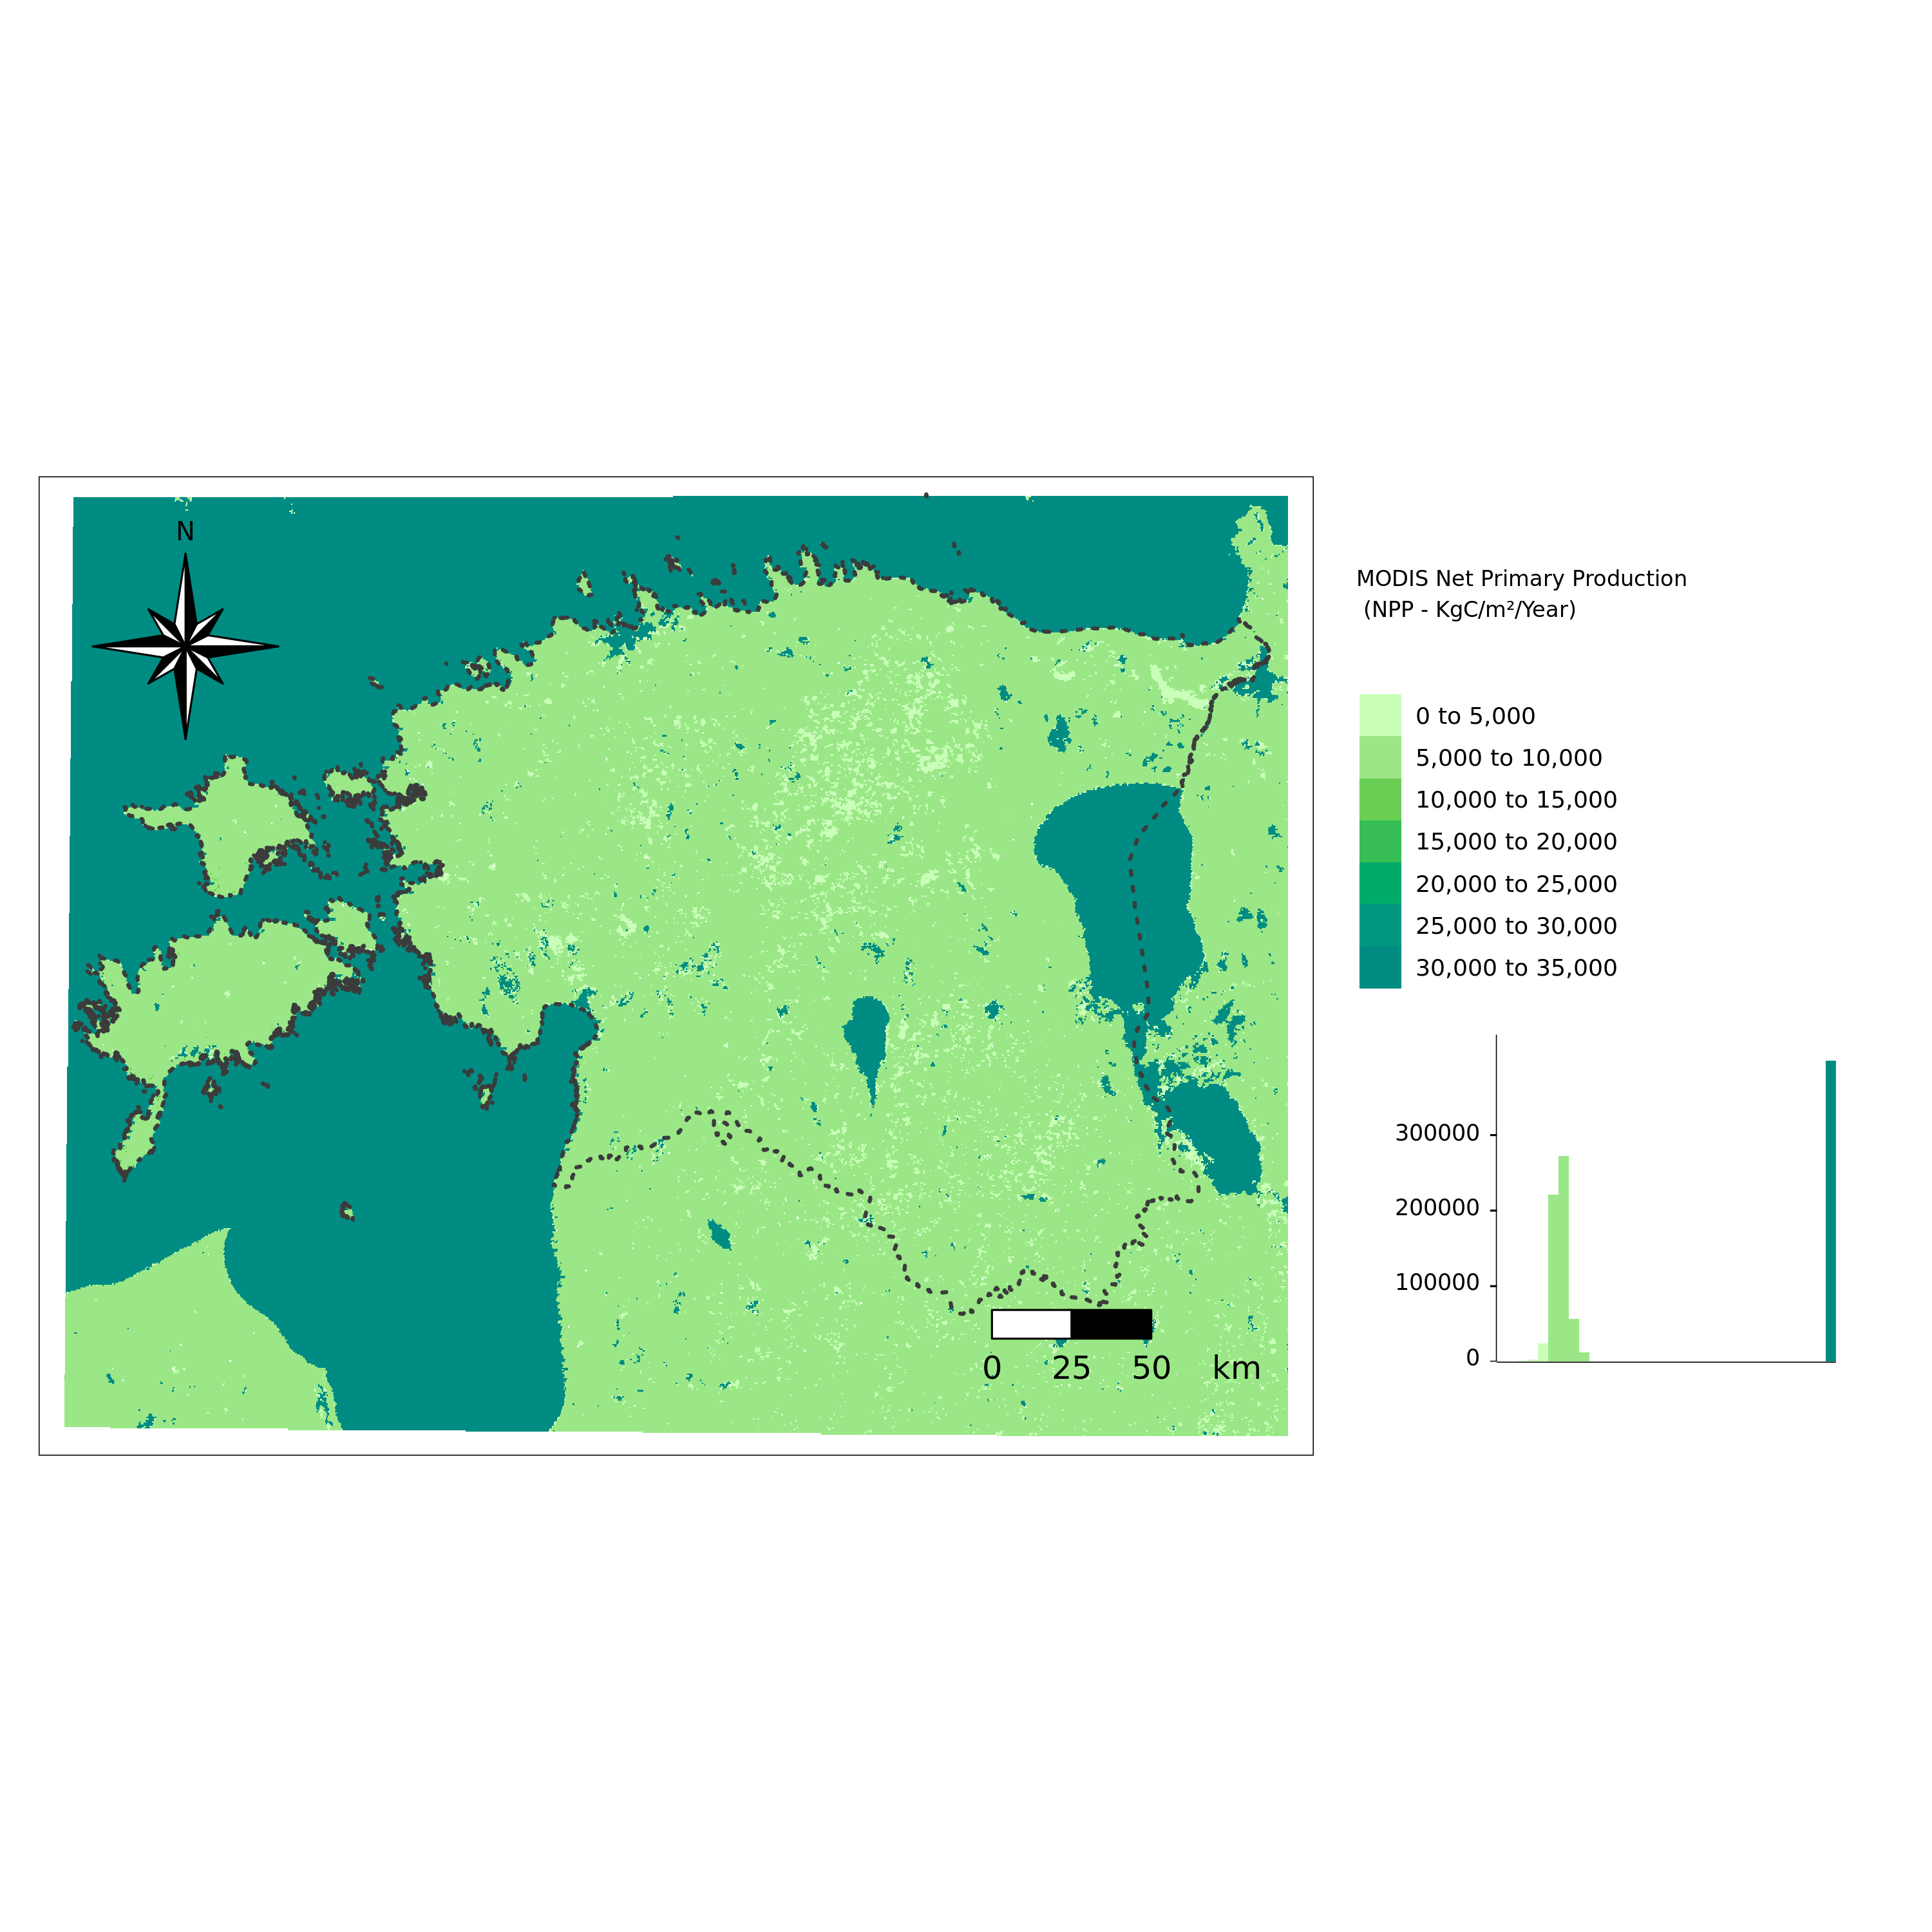

In [8]:
## Let's explore MODIS NPP rasters! Plot one MODIS NPP row raster to see how it looks
npp_fst_rst<-rast(npp_rst[1])		##select and open the first raster from npp_rst
npp_col <- c ("#c9ffb9","#9be787","#6ace55","#37bd55","#00ab69","#009780","#008c83")	##set color scheme for NPP map
options(repr.plot.width = 10, repr.plot.height =10, repr.plot.res = 300, scipen=999)		##set options of the figure size

tm_shape(npp_fst_rst)+
	tm_raster(style = "fixed", 
		title = "MODIS Net Primary Production\n (NPP - KgC/m²/Year)", 
		breaks = c(0, 5000, 10000, 15000, 20000, 25000, 30000, 35000),
            palette = npp_col,
		 legend.hist = TRUE )+
	tm_legend(outside = TRUE,
		legend.title.size = 2,
		legend.text.size =1,
		hist.width = 2,
		hist.height = 0.5)+ 
	tm_scale_bar(position=c("right", "bottom"),
			lwd = 1,
			breaks = c(0, 25, 50), 
			text.size = 1)+
	tm_shape(est_shp) + 
	tm_polygons(col=NA, 
			border.col="gray23", 
			alpha=0, 
			lty = "dotted",
			lwd = 2)+
	tm_compass(type = "8star", position = c("left", "top"))

## Look at the NPP values distribution. 
## Does it look suspicious? Have you noticed that there are NPP data over the Baltic Sea?  

## NPP MODIS processing 
MODIS NPP raw values have to be masked out over non-vegetated areas (such as Baltic Sea) and scaled. For this, we will use a matrix with the reclassification scheme that represents the range of values defined on the NPP user __[user guide document](https://lpdaac.usgs.gov/documents/495/MOD17_User_Guide_V6.pdf )__. We use "##" to mark the comments and "#" to mark the code line. Therefore, if you wanna run the code line, you need to remove the "#" of the respective line. 

In [14]:
##Create matrix with the reclassification scheme
#npp_reclass_mtx <- c(-Inf,-30001, NA,	##values from -Inf to -30001 will become NaN
                    #32701,Inf,NA)		##values from 32701 to Inf will become NaN
#npp_reclass_mtx <- matrix(npp_reclass_mtx, ncol=3, byrow=TRUE)
#npp_reclass_mtx		#matrix for reclassification 

In [15]:
## Prepare forest cover data to be used for NPP clipping
## Let's see the properties of forest_shp file
#glimpse(forest_shp)

## Projection of forest_shp is Lambert_Azimuthal_Equal_Area 
## crs = +proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs
##Let's see what is the coordinate reference system for npp_fst_rst file
#crs(npp_fst_rst)
#st_crs(npp_fst_rst) == st_crs(forest_cover_rst)	#FALSE means that coordinate reference systems are not equal



For geospatial analysis, we need to have data in the same coordinate reference system. We will use **forest_cover_rst** projection for all other spatial data, since this projection accurately represents area.


In [16]:
#newproj<-"+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs" 	#set the projection

In [17]:
## Rasterize the Estonian limits shapefile to speed up the clipping process below
#glimpspe(npp_fst_rst)
#npp_proj_rst<-projectRaster(npp_fst_rst, crs=newproj,res=500)	#reproject raster
#forest_rst<-rasterize(forest_shp, npp_proj_rst)	#rasterized forest_shp

In [18]:
## Extract and rename the NPP .tif files according to the date of acquisition presented in the file name
#npp_short_list <-as.character(substr(npp_list,28,31))
#npp_short_list<- paste("MODIS_NPP",npp_short_list, sep = "_")
#npp_short_list<-paste( npp_short_list,".tif", sep = "")
#npp_short_list

Clip MODIS NPP data based on forest data; at the same time, the rasters will be reclassified and reprojected.

In [34]:
#No need to run this code!

#for (i in 1:length(npp_rst)){  			#we work with MODIS NPP rasters 
#  r<-rast(npp_rst[i])					#rast function creates a SpatRaster object
#  r <- classify(r,npp_reclass_mtx)			#reclassify based on npp_reclass_mtx matrix
#  r<-raster(r)						#convert the SpatRaster object to a RasterLayer object
#  r<-projectRaster(r, crs=newproj,res=500)	#reproject raster
#  r<-crop(r, forest_rst)				#crop SpatRaster object based on forest_b350_rst
#  r<-mask(r,forest_rst,updatevalue=NA)		#mask SpatRaster object exactly at the forest border and assign NA values for pixels outside the border
#  r<-r*0.0001						#scale factor to convert NPP values to KgC/m2/yr
#  writeRaster(r, filename=file.path("...path",
#                                    paste0(gsub(".tif","_cut_forest.tif",npp_short_list[i]))),
#              format="GTiff", overwrite=T,  wopt= list(gdal=c("COMPRESS=LZW", "of=COG")))# save the output NPP raster
#  print(names(r))
#  print(npp_short_list[i])
#  print(i)
#  rm(r)
#}

In [21]:
## List the cut and scaled NPP rasters
#npp_clip_list<-list.files("Data/NPP_cut", pattern = "cut_forest.tif", full.names = T)
#npp_clip_list 	#21 raster files

Let's verify several cut NPP file by plotting them. We will create maps for 5 years: 2000, 2005, 2010, 2015, 2020.


In [22]:
#npp_col_scaled <- c ("#fff76a",  "#d2e603","#61b15a","#52734d", "#184d47")	#set color scheme for scaled NPP map
#breaks_npp <- c(0,0.2,0.4,0.6,0.8, 1)	#set breacks for NPP data

#tmap_mode("view")				#mode "plot" - plot static maps in R, mode "view" - plot interactive maps 
#map1<-tm_shape(rast(npp_clip_list[1]))+	#plot first NPP raster in npp_clip_list - data for 2000
#	tm_raster(breaks = breaks_npp, palette =npp_col_scaled,
#			title = "MODIS Net Primary\n Production 2000 (NPP - KgC/m²/Year)")+	#set palette and breaks for NPP raster
#	tm_shape(rast(npp_clip_list[6]))+
#	tm_raster(breaks = breaks_npp,palette =npp_col_scaled,
#			title = "MODIS Net Primary\n Production 2005 (NPP - KgC/m²/Year)")+	
#	tm_shape(rast(npp_clip_list[11]))+
#	tm_raster(breaks = breaks_npp,palette =npp_col_scaled,
#			title = "MODIS Net Primary\n Production 2010 (NPP - KgC/m²/Year)")+	
#	tm_shape(rast(npp_clip_list[16]))+
#	tm_raster(breaks = breaks_npp,palette =npp_col_scaled,
#			title = "MODIS Net Primary\n Production 2015 (NPP - KgC/m²/Year)")+	
#	tm_shape(rast(npp_clip_list[21]))+
#	tm_raster(breaks = breaks_npp,palette =npp_col_scaled,
#			title = "MODIS Net Primary\n Production 2020 (NPP - KgC/m²/Year)") 
#	
#tmap_leaflet(map1)

To make sure that we will work only with pixels that have valid NPP values during the entire time series, we need to exclude those pixels that have at least one NA value in one of the years. For that, we can use the "app" function combined with "sum" function to sum all annual rasters into one single raster. If one pixel has NA in any year, that pixels will become NA and, therefore, excluded from our further analysis.

In [23]:
## First, we need to stack the clipped all MODIS NPP raster files
#npp_rst<-rast(npp_clip_list)
#npp_rst
#names(npp_rst)

In [24]:
## Second, apply sum and app functions
#npp_sum_rst<-app(npp_rst, fun=sum)	#sum of NPP values in all the NPP rasters
#npp_sum_rst

In [26]:
## Third, plot npp_sum_rst data
#tmap_mode("view")		#interactive map
#map2<-tm_shape(npp_sum_rst)+
#	tm_raster(title = "Sum of NPP Rasters (KgC/m²)", 
#	palette =npp_col_scaled)
#tmap_leaflet(map2)

In [28]:
## Convert the NPP sum raster to shapefile
#npp_sum_shp<-as.polygons(npp_sum_rst, dissolve=FALSE)
#npp_sum_shp

## We will use the centroid of each pixel as its identifier (id)
#npp_sum_shp<-sf::st_as_sf(npp_sum_shp)	##from SpatVector to polygon
#npp_sum_shp$id<-st_centroid(npp_sum_shp$geometry)

## Split the lat and long of the centroids into columns because we will use them later for merging data frames
#npp_sum_shp <- npp_sum_shp %>%
#	mutate(long =unlist(map(npp_sum_shp$id,1)),
#		lat = unlist(map(npp_sum_shp$id,2)))
#length(unique(npp_sum_shp$id))	##gives the number of unique "ids" in npp_sum_shp file

We will intersect npp_sum_shp based on forest cover shapefile in order to retrieve the forest cover area within each pixel. The output will be the NPP pixels with forest. 

In [29]:
#npp_sum_shp <- st_transform(npp_sum_shp ,st_crs(forest_shp))	##set projection
#glimpse(npp_sum_shp)			##shapefile with correct projection

#npp_forest_shp<-st_intersection(npp_sum_shp,forest_shp,sparse = TRUE)	##areas that intersect both MODIS NPP pixels and forest core cover
#length(unique(npp_forest_shp$id))	##gives the number of unique "ids" - 534

Calculate the area of the intersected areas to later filter them leaving out areas that have less than 50% (~12.5 ha) forest cover.

In [33]:
#npp_forest_shp <-npp_forest_shp%>%
#	dplyr::mutate(area_ha=as.numeric(st_area(npp_forest_shp)/10000))%>%	##calculate the area in hectares
#	filter(area_ha > 12.5)%>%	##filter out objects with area less than 12.5 ha
#	dplyr::select(-c(sum, DN))	##remove column sum and DN
#length(unique(npp_forest_shp$id))	##gives the number of unique "ids", now we have less pixels - 353

Now we have the pixels wtih >50% (>12.5 ha) of its area covered with core forest areas. We will continue our analysis only with those pixels. For this, we will convert the annual raster to polygons and then to data frame and filter out all the pixels' ids that are not included into **npp_forest_shp$id**.


In [41]:
## List the cut and scaled NPP rasters
npp_clip_list<-list.files("Data/NPP_cut", pattern = "cut_forest.tif", full.names = T)
npp_clip_list 	#21 raster files

## First, we need to stack the clipped all MODIS NPP raster files
npp_rst<-rast(npp_clip_list)
npp_rst
names(npp_rst)

[1] "Data/NPP_cut/MODIS_NPP_2000_cut_forest.tif"
 [2] "Data/NPP_cut/MODIS_NPP_2001_cut_forest.tif"
 [3] "Data/NPP_cut/MODIS_NPP_2002_cut_forest.tif"
 [4] "Data/NPP_cut/MODIS_NPP_2003_cut_forest.tif"
 [5] "Data/NPP_cut/MODIS_NPP_2004_cut_forest.tif"
 [6] "Data/NPP_cut/MODIS_NPP_2005_cut_forest.tif"
 [7] "Data/NPP_cut/MODIS_NPP_2006_cut_forest.tif"
 [8] "Data/NPP_cut/MODIS_NPP_2007_cut_forest.tif"
 [9] "Data/NPP_cut/MODIS_NPP_2008_cut_forest.tif"
[10] "Data/NPP_cut/MODIS_NPP_2009_cut_forest.tif"
[11] "Data/NPP_cut/MODIS_NPP_2010_cut_forest.tif"
[12] "Data/NPP_cut/MODIS_NPP_2011_cut_forest.tif"
[13] "Data/NPP_cut/MODIS_NPP_2012_cut_forest.tif"
[14] "Data/NPP_cut/MODIS_NPP_2013_cut_forest.tif"
[15] "Data/NPP_cut/MODIS_NPP_2014_cut_forest.tif"
[16] "Data/NPP_cut/MODIS_NPP_2015_cut_forest.tif"
[17] "Data/NPP_cut/MODIS_NPP_2016_cut_forest.tif"
[18] "Data/NPP_cut/MODIS_NPP_2017_cut_forest.tif"
[19] "Data/NPP_cut/MODIS_NPP_2018_cut_forest.tif"
[20] "Data/NPP_cut/MODIS_NPP_2019_cut_forest.tif"
[21] "Data/NPP_cut/MODIS_NPP_2020_cut_forest.tif"

class       : SpatRaster 
dimensions  : 748, 889, 21  (nrow, ncol, nlyr)
resolution  : 500, 500  (x, y)
extent      : 4974020, 5418520, 3840324, 4214324  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs 
sources     : MODIS_NPP_2000_cut_forest.tif  
              MODIS_NPP_2001_cut_forest.tif  
              MODIS_NPP_2002_cut_forest.tif  
              ... and 18 more source(s)
names       : MODIS~orest, MODIS~orest, MODIS~orest, MODIS~orest, MODIS~orest, MODIS~orest, ... 
min values  :   0.5120256,   0.5060448,   0.5644055,   0.4991340,   0.4670867,   0.5433198, ... 
max values  :   0.8771858,   0.7291971,   0.9156720,   0.7745390,   0.7757974,   0.8131440, ... 

[1] "MODIS_NPP_2000_cut_forest" "MODIS_NPP_2001_cut_forest"
 [3] "MODIS_NPP_2002_cut_forest" "MODIS_NPP_2003_cut_forest"
 [5] "MODIS_NPP_2004_cut_forest" "MODIS_NPP_2005_cut_forest"
 [7] "MODIS_NPP_2006_cut_forest" "MODIS_NPP_2007_cut_forest"
 [9] "MODIS_NPP_2008_cut_forest" "MODIS_NPP_2009_cut_forest"
[11] "MODIS_NPP_2010_cut_forest" "MODIS_NPP_2011_cut_forest"
[13] "MODIS_NPP_2012_cut_forest" "MODIS_NPP_2013_cut_forest"
[15] "MODIS_NPP_2014_cut_forest" "MODIS_NPP_2015_cut_forest"
[17] "MODIS_NPP_2016_cut_forest" "MODIS_NPP_2017_cut_forest"
[19] "MODIS_NPP_2018_cut_forest" "MODIS_NPP_2019_cut_forest"
[21] "MODIS_NPP_2020_cut_forest"

tmap mode set to interactive viewing

Warning message in showSRID(SRS_string, format = "PROJ", multiline = "NO"):
“Discarded datum Unknown_based_on_GRS80_ellipsoid in CRS definition”
Warning message in repr_html.htmlwidget(obj):
“Inserting HTML strings into <head> is currently not supported”


HTML widgets cannot be represented in plain text (need html)
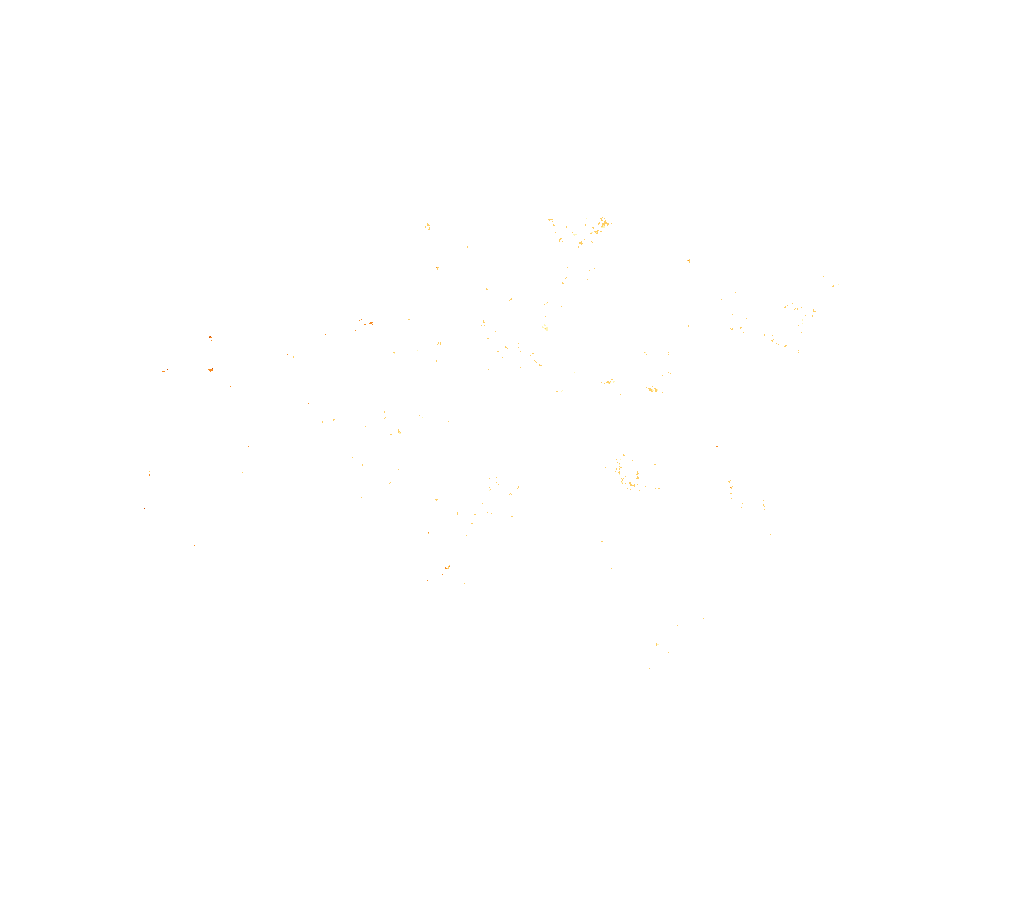

In [46]:
tmap_mode("view")		#interactive map
map2<-tm_shape(npp_rst[[1]])+
	tm_raster(title = "NPP-2001 (KgC/m²)")
	#palette =npp_col_scaled)
tmap_leaflet(map2)

In [47]:
# import the core forest cover data as shapefile 
download.file("https://github.com/LandscapeGeoinformatics/ESP2021_workshop/raw/main/Data/shp/npp_forest_shp_inter.zip", destfile="npp_forest_shp_inter.zip")
unzip("npp_forest_shp_inter.zip")
npp_forest_shp <-  st_read("npp_forest_shp_inter.shp")

npp_forest_shp$id<-st_centroid(npp_forest_shp$geometry)

## Split the lat and long of the centroids into columns because we will use them later for merging data frames
npp_forest_shp <- npp_forest_shp %>%
	mutate(long =unlist(map(npp_forest_shp$id,1)),
		lat = unlist(map(npp_forest_shp$id,2)))
length(unique(npp_forest_shp$id))

glimpse(npp_forest_shp)

Reading layer `npp_forest_shp' from data source `/home/jovyan/npp_forest_shp.shp' using driver `ESRI Shapefile'
Simple feature collection with 353 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 5023020 ymin: 3955824 xmax: 5337020 ymax: 4157324
Projected CRS: Lambert_Azimuthal_Equal_Area
Rows: 353
Columns: 4
$ long     <dbl> 5223770, 5211270, 5334770, 5218270, 5217770, 5218270, 5218270…
$ lat      <dbl> 4155574, 4155074, 4154574, 4154574, 4154074, 4154074, 4157074…
$ area_ha  <dbl> 24.97473, 16.79974, 13.07080, 14.53966, 22.91402, 24.00209, 2…
$ geometry <MULTIPOLYGON [m]> MULTIPOLYGON (((5223520 415..., MULTIPOLYGON (((…


In [50]:
npp_annual_shp <-as.polygons(npp_rst, dissolve=FALSE)
head(npp_annual_shp, n=10)			# shows the first rows of each column of the dataframe
npp_annual_shp<-sf::st_as_sf(npp_annual_shp)	#from SpatVector to polygon
npp_annual_shp$id<-st_centroid(npp_annual_shp$geometry)	#create column id
colnames(npp_annual_shp)			# see that new id column appears

npp_annual_df<-as.data.frame(npp_annual_shp)	# we have to convert to data.frame because several needed functions work only with data frames
glimpse(npp_annual_df)					#see the data frame
npp_forest_df<-as.data.frame(npp_forest_shp)	#also convert to data frame


,MODIS_NPP_2000_cut_forest,MODIS_NPP_2001_cut_forest,MODIS_NPP_2002_cut_forest,MODIS_NPP_2003_cut_forest,MODIS_NPP_2004_cut_forest,MODIS_NPP_2005_cut_forest,MODIS_NPP_2006_cut_forest,MODIS_NPP_2007_cut_forest,MODIS_NPP_2008_cut_forest,MODIS_NPP_2009_cut_forest,⋯,MODIS_NPP_2011_cut_forest,MODIS_NPP_2012_cut_forest,MODIS_NPP_2013_cut_forest,MODIS_NPP_2014_cut_forest,MODIS_NPP_2015_cut_forest,MODIS_NPP_2016_cut_forest,MODIS_NPP_2017_cut_forest,MODIS_NPP_2018_cut_forest,MODIS_NPP_2019_cut_forest,MODIS_NPP_2020_cut_forest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6655362,0.6222938,0.6813736,0.5683485,0.5914342,0.6108335,0.6357298,0.7033457,0.7324509,0.7209697,⋯,0.6904300,0.7071546,0.6492552,0.6258748,0.6882699,0.7215336,0.7017298,0.6888019,0.7179587,0.7132459
2,0.6112794,0.5761122,0.6333906,0.5466067,0.5719839,0.6360472,0.6044568,0.6973874,0.7052873,0.7025284,⋯,0.6252052,0.6992341,0.6431337,0.6028482,0.7183936,0.6817666,0.6787208,0.6615148,0.6849054,0.7119418
3,0.6144042,0.5797853,0.6306392,0.5690926,0.5600067,0.6291383,0.6225019,0.6812235,0.6892730,0.6812771,⋯,0.6743379,0.7171085,0.6447926,0.6340171,0.7067283,0.7002332,0.6896144,0.6547424,0.6975863,0.7080480
4,0.6322366,0.5838443,0.6541811,0.5591877,0.5713459,0.6267968,0.6323905,0.7004063,0.7027535,0.7014248,⋯,0.6405444,0.7200272,0.6336012,0.6406202,0.7104625,0.6834134,0.6821254,0.6597775,0.6913109,0.7129352
5,0.6254870,0.5769086,0.6497679,0.5527953,0.5621286,0.6369949,0.6010051,0.6978585,0.7151330,0.6783917,⋯,0.6426936,0.7040721,0.6187369,0.6461067,0.7133098,0.6939440,0.6881200,0.6603870,0.6892333,0.6947458
6,0.6262960,0.5925604,0.6516342,0.5679215,0.5573223,0.6188709,0.6029215,0.6841692,0.6868257,0.6805789,⋯,0.6694656,0.6971413,0.6590171,0.5987444,0.7200117,0.6783071,0.6958547,0.6675282,0.6867319,0.7098613
7,0.6439148,0.5945579,0.6528087,0.5621541,0.5808423,0.6467371,0.6141135,0.6941581,0.7296652,0.7092587,⋯,0.6809428,0.7328145,0.6319009,0.6428539,0.7278304,0.6917959,0.6889799,0.6815390,0.7121924,0.7254969
8,0.6434388,0.5954294,0.6513873,0.5769297,0.5596925,0.6411875,0.6124949,0.6932660,0.7186438,0.6916780,⋯,0.6542141,0.7186500,0.6437020,0.6228976,0.7248935,0.6985388,0.6937643,0.6715391,0.6957506,0.7081221
9,0.6353952,0.5877851,0.6474898,0.5636060,0.5652527,0.6124704,0.5882952,0.6865875,0.6994655,0.6838424,⋯,0.6464486,0.7081698,0.6515765,0.6131923,0.7198633,0.6764299,0.6863348,0.6702917,0.6939115,0.6941628


[1] "MODIS_NPP_2000_cut_forest" "MODIS_NPP_2001_cut_forest"
 [3] "MODIS_NPP_2002_cut_forest" "MODIS_NPP_2003_cut_forest"
 [5] "MODIS_NPP_2004_cut_forest" "MODIS_NPP_2005_cut_forest"
 [7] "MODIS_NPP_2006_cut_forest" "MODIS_NPP_2007_cut_forest"
 [9] "MODIS_NPP_2008_cut_forest" "MODIS_NPP_2009_cut_forest"
[11] "MODIS_NPP_2010_cut_forest" "MODIS_NPP_2011_cut_forest"
[13] "MODIS_NPP_2012_cut_forest" "MODIS_NPP_2013_cut_forest"
[15] "MODIS_NPP_2014_cut_forest" "MODIS_NPP_2015_cut_forest"
[17] "MODIS_NPP_2016_cut_forest" "MODIS_NPP_2017_cut_forest"
[19] "MODIS_NPP_2018_cut_forest" "MODIS_NPP_2019_cut_forest"
[21] "MODIS_NPP_2020_cut_forest" "geometry"                 
[23] "id"

Rows: 534
Columns: 23
$ MODIS_NPP_2000_cut_forest <dbl> 0.6655362, 0.6112794, 0.6144042, 0.6322366, …
$ MODIS_NPP_2001_cut_forest <dbl> 0.6222938, 0.5761122, 0.5797853, 0.5838443, …
$ MODIS_NPP_2002_cut_forest <dbl> 0.6813736, 0.6333906, 0.6306392, 0.6541811, …
$ MODIS_NPP_2003_cut_forest <dbl> 0.5683485, 0.5466067, 0.5690926, 0.5591877, …
$ MODIS_NPP_2004_cut_forest <dbl> 0.5914342, 0.5719839, 0.5600067, 0.5713459, …
$ MODIS_NPP_2005_cut_forest <dbl> 0.6108335, 0.6360472, 0.6291383, 0.6267968, …
$ MODIS_NPP_2006_cut_forest <dbl> 0.6357298, 0.6044568, 0.6225019, 0.6323905, …
$ MODIS_NPP_2007_cut_forest <dbl> 0.7033457, 0.6973874, 0.6812235, 0.7004063, …
$ MODIS_NPP_2008_cut_forest <dbl> 0.7324509, 0.7052873, 0.6892730, 0.7027535, …
$ MODIS_NPP_2009_cut_forest <dbl> 0.7209697, 0.7025284, 0.6812771, 0.7014248, …
$ MODIS_NPP_2010_cut_forest <dbl> 0.6216192, 0.6034526, 0.5923437, 0.6159555, …
$ MODIS_NPP_2011_cut_forest <dbl> 0.6904300, 0.6252052, 0.6743379, 0.6405444, …
$ MODIS_NPP_2012_c

In [49]:
## filter by the ids to retrieve only those pixels with >50% of core forest cover
npp_df <- npp_annual_df %>% filter(id %in% npp_forest_df$id)
glimpse(npp_df)							#this is data frame that contains yearly NPP values for forested pixels

[1] "MODIS_NPP_2000_cut_forest" "MODIS_NPP_2001_cut_forest"
 [3] "MODIS_NPP_2002_cut_forest" "MODIS_NPP_2003_cut_forest"
 [5] "MODIS_NPP_2004_cut_forest" "MODIS_NPP_2005_cut_forest"
 [7] "MODIS_NPP_2006_cut_forest" "MODIS_NPP_2007_cut_forest"
 [9] "MODIS_NPP_2008_cut_forest" "MODIS_NPP_2009_cut_forest"
[11] "MODIS_NPP_2010_cut_forest" "MODIS_NPP_2011_cut_forest"
[13] "MODIS_NPP_2012_cut_forest" "MODIS_NPP_2013_cut_forest"
[15] "MODIS_NPP_2014_cut_forest" "MODIS_NPP_2015_cut_forest"
[17] "MODIS_NPP_2016_cut_forest" "MODIS_NPP_2017_cut_forest"
[19] "MODIS_NPP_2018_cut_forest" "MODIS_NPP_2019_cut_forest"
[21] "MODIS_NPP_2020_cut_forest" "geometry"                 
[23] "id"

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


MODIS_NPP_2000,MODIS_NPP_2001,MODIS_NPP_2002,MODIS_NPP_2003,MODIS_NPP_2004,MODIS_NPP_2005,MODIS_NPP_2006,MODIS_NPP_2007,MODIS_NPP_2008,MODIS_NPP_2009,⋯,MODIS_NPP_2013,MODIS_NPP_2014,MODIS_NPP_2015,MODIS_NPP_2016,MODIS_NPP_2017,MODIS_NPP_2018,MODIS_NPP_2019,MODIS_NPP_2020,geometry,id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<GEOMETRY [m]>,<GEOMETRY [m]>


Explore the NPP data with a boxplot figure. We will create boxplots for each year.

In [ ]:
## First, combine the data of different years columns into a single column with separate rows for each year
npp_df_boxplot <- gather(npp_df[,1:21])		##we have a new data frame with two columns: key (MODIS year) and NPP value
str(npp_df_boxplot)					##this data rame does not contain any spatial information (geometry, id)
npp_df_boxplot$year <- as.factor(substr(npp_df_boxplot$key,11,14))	##add a new column with year

## For each year calculate quantiles 0.25, 0.5 and 0.75
quants_df<-npp_df_boxplot %>% 
  dplyr::group_by(year) %>% 
  dplyr::summarize(quants25 = quantile(value, probs = 0.25),
			quants50 = quantile(value, probs = 0.5),
			quants75 = quantile(value, probs = 0.75))%>%
	ungroup()%>%
	mutate_if(is.numeric, round, digits=2)
summary(quants_df)

In [ ]:
## Create boxplot of NPP values by years with added values of quantiles
options(repr.plot.width = 15, repr.plot.height =8, repr.plot.res = 300)

ggplot()+
	stat_boxplot(data=npp_df_boxplot, aes(x=year, y=value), 
				geom = "errorbar", 
				width = 0.3,
				lwd=1,
				color="#d1d9d9")+
	geom_boxplot(data=npp_df_boxplot, aes(x=year, y=value),
				outlier.alpha = 0.1,
				color="#d1d9d9",
				fill="#cdc7be")+
	geom_text(data =quants_df, aes(x = year, y = quants25, label =quants25), 
				color = "#387c6d", 
				size = 4, 
				vjust = 1.5, 
				fontface="bold")+
	geom_text(data =quants_df, aes(x = year, y = quants50, label =quants50), 
				color = "#db6400", 
				size = 4, 
				vjust = -0.5, 
				fontface="bold")+
	geom_text(data =quants_df, aes(x = year, y = quants75, label =quants75), 
				color = "#f05454", 
				size = 4, 
				vjust =-1, 
				fontface="bold")+
	theme(plot.title = element_text( size=14, face="bold"),
		axis.title.x = element_text(size=14, face="bold"),
		axis.title.y = element_text(size=14, face="bold"),
		axis.text = element_text(size=12),
		panel.background = element_rect(fill = "white", colour = "grey50"))+ 
	labs(x ="Years", y = "MODIS NPP")

## Mann-Kendall test
As the Mann-Kendall test will be applied for every single pixel, we have to apply some modifications in the data frame. We will convert a wide version of data frame npp_df (with 23 columns and 353 rows) to the long data frame (with 8 columns and 7413 rows).

In [ ]:
npp_long_df <- npp_df %>% 
		gather(date,		##the name of key column - will include the names of MODIS files
			npp_annual_value,	##the name of column with NPP data
			"MODIS_NPP_2000":"MODIS_NPP_2020")	##colums that we gather in a new data frame

head(npp_df, n=5)		##see the columns of the initial wide data frame
head(npp_long_df, n=5)		##see the columns of long data frame

In [ ]:
npp_long_df$year<-as.integer(substr(npp_long_df$date,11,14))	##create a column with the years information
npp_long_df <- npp_long_df %>%						##create lat and long columns
	mutate(long = unlist(map(npp_long_df$id,1)),
		lat = unlist(map(npp_long_df$id,2)))
head(npp_long_df, n=3)

Now we can move to the Mann-Kendall calculation itself.

In [ ]:
## First, sort the data frame in chronological order for each "lat" and "long"
npp_long_df <- npp_long_df[order(npp_long_df$lat,npp_long_df$long,
                                              npp_long_df$year),]
npp_long_df[1:45,]	##show first 45 rows - check if the sorting worked

In [ ]:
## Create a function to calculate the annual trends for NPP
coef.fcn = function(newdata) {
	res<-mannKen(newdata$npp_annual_value)
	return(as.data.frame(res))
}

## The Mann-Kendall test will be applied per groups of lat and long combinations
npp_trend_df = npp_long_df %>% 
	group_by(long, lat)%>%
	do(coef.fcn(.))
head(npp_trend_df, n=5)	##see the Mann-Kendall test statistics

## Categorize the trends in increase, decrease or no-trend according to the p-value (significance)
npp_trend_df$trend<-ifelse(npp_trend_df$sen.slope < 0 & 
					npp_trend_df$p.value<0.05, "Decrease", 
				ifelse(npp_trend_df$sen.slope >0 & 
					npp_trend_df$p.value<0.05, "Increase", "No trend"))
head(npp_trend_df, n=5)
unique(npp_trend_df$trend)	##no negative NPP trends
table(npp_trend_df$trend)

We can plot the results on the map now. For that, we need to merge the Mann-Kendall test results with the shapefile **"npp_sum_shp"**.


In [ ]:
trend_shp<-merge(npp_forest_shp,npp_trend_df, by=c("long","lat"))	
summary(trend_shp)

In [ ]:
## Create a map of NPP trends
tmap_mode("view")

map3<-tm_shape(forest_shp) + 
		tm_polygons(col="#4aa96c", border.col="#4aa96c")+ 	##core forest areas are shown with green colour
	tm_shape(trend_shp[trend_shp$trend=="Increase",])+
		tm_polygons(col="#fb3640", border.col="#fb3640")+	##areas of increasing NPP trend are shown with red colour
	tm_shape(trend_shp[trend_shp$trend=="No trend",])+
		tm_polygons(col="#ffc93c", border.col="#ffc93c")	##areas of non-significant trend are shown with orange colour
tmap_leaflet(map3)

In [ ]:
## Create a map with the Sen's slope values
tmap_mode("view")

map4<-tm_shape(trend_shp)+
		tm_polygons("sen.slope", 
				title="Sen's Slope",
				palette =npp_col_scaled, 
				border.col=NULL)	
tmap_leaflet(map4)

We can multiply the Sen's slope values of each pixels with the respective forest core area to retrieve the total amount of carbon assimilated by that area.

In [ ]:
trend_shp$total_carbon<-trend_shp$area_ha*10000*trend_shp$sen.slope
summary(trend_shp)
tmap_mode("view")

map5<-tm_shape(trend_shp)+
		tm_polygons("total_carbon", 
				title="Kg C/Year ",
				palette = npp_col_scaled, 
				border.col=NULL)
tmap_leaflet(map5)

## Coefficient of NPP variation
We will calculate a coefficient of variation, and we will see how much (in %) each MODIS NPP pixel varies.

In [ ]:
variation_df<-npp_long_df%>%
		group_by(lat, long)%>%		##group data by coordinates
		dplyr::summarise(coef_var=sd(npp_annual_value)/mean(npp_annual_value)*100) ## calculate coefficient of variation

## Merge data frame with shapefile 
variation_shp<-merge(npp_forest_shp,variation_df, by=c("long","lat"))	

## Pot the coefficient of variation for NPP data
tmap_mode("view")
map5<-tm_shape(forest_shp) + 
		tm_polygons(col="#4aa96c", border.col="#4aa96c")+ 	##core forest areas are shown with green colour
	tm_shape(variation_shp) + 
		tm_polygons(col="coef_var",title = "NPP Coefficient of Variation (%)", 
				border.col = NULL)
tmap_leaflet(map5)

## NPP anomalies
We can calculate annual anomalies. For that, we will be calculating the historical NPP mean for the whole period, the annual mean, and standard deviation. The anomalies are calculated as: 
\begin{equation*}
z =  \frac{Annual Mean - Historical Mean}{Historical Standard Deviation}
\quad\quad \
\end{equation*}

In [ ]:
npp_yr_anom_df<-npp_long_df%>% group_by(year) %>% 
	dplyr::summarise(annual_mean = mean(npp_annual_value))	
npp_historical_mean<-mean(npp_yr_anom_df$annual_mean)
npp_historical_sd<-sd(npp_yr_anom_df$annual_mean)
npp_yr_anom_df$anom <- (npp_yr_anom_df$annual_mean - npp_historical_mean)/npp_historical_sd
summary(npp_yr_anom_df)

In [ ]:
## Classify the anomalies in + and - to use later in the plotting
npp_yr_anom_df$sign_anom<-ifelse(npp_yr_anom_df$anom >0,"+",
				ifelse(npp_yr_anom_df$anom==0,"NA","-"))
head(npp_yr_anom_df, n=5)
table(npp_yr_anom_df$sign_anom)

Plot yearly NPP anomalies


In [ ]:
options(repr.plot.width = 15, repr.plot.height =8, repr.plot.res = 300)

ggplot(npp_yr_anom_df, aes(x=as.factor(year),y=anom, fill = sign_anom))+
		## Show 95%  confidence interval for anomalies (1.96)
	geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=-1.96, ymax=1.96), fill="#f4f4f2")+	##area of 95% CI
	geom_hline(yintercept = c(-2,-1,1,2),colour = "#dbdbdb", alpha=0.7, size=0.5)+	##line of 02, -1, 1 and 2 NPP anomalies
		## Plot yearly anomalies
	geom_bar(stat = "identity") + 
		## Plot values of yearly aomalies
	geom_text(data= npp_yr_anom_df[npp_yr_anom_df$anom>0,],		##positive values
			aes(label = round(anom,2), color=sign_anom), 
				size = 4, 
				vjust = -1, 
				fontface="bold")+
	geom_text(data= npp_yr_anom_df[npp_yr_anom_df$anom<0,],		##negative values
			aes(label = round(anom,2), color=sign_anom), 
				size = 4, 
				vjust = 1, 
				fontface="bold")+
	scale_color_manual(values = c( "#1f6f8b", "#f05454"))+	##set text coulours
	scale_fill_manual(values = c( "#1f6f8b", "#f05454")) +	##set varplot fill colours
	labs(y = "NPP anomalies (Z-score)", x = "Years")+		##labs names
	theme(text = element_text(size = 14),				##properties of the theme
		axis.title = element_text(size=14, face="bold"),
		legend.position = "none",
		panel.background = element_rect(fill = "white", colour = "grey50"))+
	geom_hline(yintercept = c(0),colour = "#495464", alpha=0.7)+	##horizontal line at y=0
	ylim(-2.5,2.5)			##y-axis limits

In [ ]:
## Calculate anomalies pixel-wise
anom_pixel_df<-npp_long_df%>%
		dplyr::mutate(anom_pixel=((npp_annual_value-npp_historical_mean)/npp_historical_sd))

anom_pixel_df$sign_anomalies<-ifelse(anom_pixel_df$anom_pixel>0,"+",
					ifelse(anom_pixel_df$anom_pixel==0,"NA","-"))
summary(anom_pixel_df)		##anomalies vary from 6.772 to -4.923

Plot NPP anomalies per pixel

In [ ]:
options(repr.plot.width = 15, repr.plot.height =8, repr.plot.res = 300)

ggplot(anom_pixel_df, aes(x=as.factor(year),y=anom_pixel, fill=sign_anomalies))+
		## Show 95%  confidence interval for anomalies (1.96)
	geom_rect(aes(xmin=-Inf, xmax=Inf, ymin=-1.96, ymax=1.96), fill="#f4f4f2")+	##area of 95% CI
	geom_hline(yintercept = c(seq(-8, 8, by = 1)),colour = "#dbdbdb", alpha=0.7, size=0.5)+	
	geom_hline(yintercept = c(0),colour = "#495464", alpha=0.7)+	##horizontal line at y=0
		## Plot yearly anomalies
	stat_boxplot(geom = "errorbar", lwd=1,color="#bbbfca")+
	geom_boxplot(outlier.alpha = 0.2,color="#bbbfca")+
	labs(y = "NPP anomaly (Z-score)", x = "Years")+
	theme(text = element_text(size = 14),				##properties of the theme
		axis.title = element_text(size=14, face="bold"),legend.position = "none",
		panel.background = element_rect(fill = "white", colour = "grey50"))+
	scale_fill_manual(values = c( "#1f6f8b", "#f05454")) +	##set varplot fill colours
	scale_y_continuous(breaks=seq(-7, 7, by = 1),limits=c(-7,7))

In [ ]:
## Merge data frame with shapefile 
anom_pixel_df<-anom_pixel_df%>% select(lat, long,anom_pixel, year)	##select only needed columns
anomalies_shp<-merge (npp_forest_shp, anom_pixel_df,  by=c("long","lat"))	##shapefile of anomalies
summary(anomalies_shp)

Plot anomalies nearby Lahemaa as gif

In [ ]:
Lahemaa_area_list = list(rbind(c(5180000, 4130000), 
				c(5180000, 4165000), 
				c(5230000 , 4165000), 
				c(5230000 , 4130000), 
				c(5180000, 4130000)))
Lahemaa_area_shp<-st_polygon(Lahemaa_area_list) 
Lahemaa_area_shp = st_sfc(Lahemaa_area_shp, crs = newproj)

#npp_forest_shp Crop data to Lahemaa area
anomalies_crop_shp<-st_crop(anomalies_shp, xmin = 5180000, ymin = 4130000, xmax = 5230000 , ymax = 4165000)	#crop anomalies shp
forest_crop_rst <- crop(forest_cover_rst, extent(5180000, 5230000 , 4130000, 4165000))		#crop forest raster

In [ ]:
cols_forest <- c("#f8ede3", "#cfdac8")
br<- c(-5,-4,-3,-2,-1,0, 1 , 2 , 3, 4, 5, 6, 7)
lab<-c ("No forest", "Forest")

tmap_mode("plot")
animation_fig <-tm_shape(Lahemaa_area_shp) +					##area of interest
			tm_polygons(col="#d3e0ea", border.col=NULL)+ 	
		tm_shape(forest_crop_rst)+						##forest cover
			tm_raster(style = "fixed", title = "Forest Cover in Estonia",
				breaks = c(0,0.5, 1), palette = cols_forest,labels = lab)+
		tm_shape(anomalies_crop_shp) + 					##anomalies
			tm_polygons(col="anom_pixel",border.col = NULL,breaks = br, title = "NPP Anomalies")+
		tm_scale_bar(position=c("left", "bottom"),
			lwd = 1,breaks = c(0, 2.5, 5), text.size = 1)+
		tm_layout(legend.position = c("right","bottom"))+
		tm_facets(along = "year")						##parameter to animate
tmap_animation(animation_fig,"animation_fig.gif", loop = TRUE, delay = 70)	##save animation to local drive

To see the **animation_fig.gif** file you need:<br>
1) copy the link of this tab;<br>
2) delete the last part after andscapegeoinf-sp2021_workshop-********;<br>
3) add "tree" to the link;<br>
The final link should look like https://hub.gke2.mybinder.org/user/landscapegeoinf-sp2021_workshop-8kbaogtt/tree.